In [52]:
'''
This script categorizes the splicing status of each intron in long read data
Author: Kirsten Reimer
Date: 31 Mar 2020
'''

'\nThis script categorizes the splicing status of each intron in long read data\nAuthor: Kirsten Reimer\nDate: 31 Mar 2020\n'

In [1]:
import os

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import mygene
import itertools
import scipy
import pysam

from plotnine import *
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # export pdfs with editable font types in Illustrator

### Part 1: Classify reads based on entire intron coverage

In [26]:
# Set links to intron annotation file in BED format and list of active TSSs (defined from PROseq data)
all_introns = pd.read_csv('../annotation_files/mm10_VM20_introns.bed.gz', delimiter = '\t', names =  ['chr', 'start', 'end', 'name', 'score', 'strand'], compression = 'gzip') # annotation of all mm10 introns in BED6 format, downloaded from USCS table browser
active_TSS = pd.read_csv('../annotation_files/active_TSS_PROseq_150_counts_mm10_VM20.txt', delimiter = '\t', header = 0)

In [27]:
# # add a column for txid
all_introns['txid'] = all_introns.name.str.split('_').str[0]

In [28]:
active_genes = active_TSS.groupby(['geneid'])
print('Number of actively transcribed genes in MEL = ' + str(len(active_genes)))

Number of actively transcribed genes in MEL = 13406


In [31]:
# Define a function to filter out introns that are not used in MEL cells according to PROseq data, i.e. introns that are upstream of active TSSs for each transcript ID
def remove_unused_introns(TSS_file, intron_file):
    
    # First get the transcript with the outermost TSS for each gene ID
    active_TSS_plus = TSS_file[TSS_file['strand'] == '+']
    active_TSS_minus = TSS_file[TSS_file['strand'] == '-']
    plus_outer = active_TSS_plus.loc[active_TSS_plus.groupby('geneid')['start'].idxmin()]
    minus_outer = active_TSS_minus.loc[active_TSS_minus.groupby('geneid')['start'].idxmax()]

    # Get transcript ID from intron ID and split introns by strand
#     intron_file['txid'] = intron_file.name.str.split('_').str[0]
    introns_plus = intron_file[intron_file['strand'] == '+']
    introns_minus = intron_file[intron_file['strand'] == '-']
    
    # Join TSS dfs and intron dfs by transcript ID
    joined_plus = pd.merge(introns_plus, plus_outer, left_on = 'txid', right_on = 'txname', how = 'left')
    joined_minus = pd.merge(introns_minus, minus_outer, left_on = 'txid', right_on = 'txname', how = 'left')

    # For each intron, check whether start is at or downstream of most active TSS
    keep_plus = joined_plus[joined_plus['start_x'] >= joined_plus['start_y']]
    keep_minus = joined_minus[joined_minus['start_x'] <= joined_minus['start_y']]
    
    joined = pd.concat([joined_plus, joined_minus])
    keep = pd.concat([keep_plus, keep_minus])
    return keep

In [33]:
active_introns = remove_unused_introns(active_TSS, all_introns)
active_introns = active_introns[['chr_x', 'start_x', 'end_x', 'name', 'score_x', 'strand_x']]
active_introns.columns = ['chr', 'start', 'end', 'name', 'score', 'strand']

In [34]:
# create a file of unique introns for later use
all_introns['start'] = all_introns['start'].astype(str)
all_introns['end'] = all_introns['end'].astype(str)

all_introns['ID'] = all_introns.chr.str.cat(all_introns.start,sep="_")
all_introns['ID'] = all_introns.ID.str.cat(all_introns.end,sep="_")
all_introns['ID'] = all_introns.ID.str.cat(all_introns.strand,sep="_")
all_introns['ID'] = all_introns['ID'].str.strip()

# drop duplicate intron coordinates
all_introns_unique = all_introns.drop_duplicates(subset = 'ID', keep = 'first')

print('Total number of introns is: ' + str(len(all_introns.index)))
print('Number of unique introns is: ' + str(len(all_introns_unique.index)))

# save unique introns with correct coordinates for downstream use
all_introns_unique.to_csv('../annotation_files/mm10_VM20_introns_unique.bed', 
               sep = '\t', 
               index = False,
               columns = ['chr', 'start', 'end', 'name', 'score', 'strand'], 
               header = False)

Total number of introns is: 679794
Number of unique introns is: 281786


In [35]:
# create a unique ID string for each intron coordinate
active_introns['start'] = active_introns['start'].astype(str)
active_introns['end'] = active_introns['end'].astype(str)

active_introns['ID'] = active_introns.chr.str.cat(active_introns.start,sep="_")
active_introns['ID'] = active_introns.ID.str.cat(active_introns.end,sep="_")
active_introns['ID'] = active_introns.ID.str.cat(active_introns.strand,sep="_")
active_introns['ID'] = active_introns['ID'].str.strip()

# drop duplicate intron coordinates
active_introns_unique = active_introns.drop_duplicates(subset = 'ID', keep = 'first')

print('Total number of introns from active transcripts is: ' + str(len(active_introns.index)))
print('Number of unique introns from active transcripts is: ' + str(len(active_introns_unique.index)))

# save unique introns with correct coordinates for downstream use
active_introns_unique.to_csv('../annotation_files/mm10_VM20_active_introns_unique_real_coordinates.bed', 
               sep = '\t', 
               index = False,
               columns = ['chr', 'start', 'end', 'name', 'score', 'strand'], 
               header = False)

Total number of introns from active transcripts is: 91583
Number of unique introns from active transcripts is: 91340


In [36]:
# add 1 nucleotide to the start and end of each intron coordinate
active_introns_unique['windowStart'] = (active_introns_unique['start'].astype('int')) - 1
active_introns_unique['windowEnd'] = (active_introns_unique['end'].astype('int')) + 1

In [37]:
# Save unique introns to file for bedtool intersect
active_unique_introns_filename = "mm10_VM20_introns_unique.bed"
active_introns_unique.to_csv(active_unique_introns_filename, 
               sep = '\t', 
               index = False, 
               columns = ['chr', 'windowStart', 'windowEnd', 'name', 'score', 'strand'], 
               header = False)

In [11]:
# Bedtools intersect to get information about which intron windows each read intersects
### THIS IS NOT WORKING WITH PYBEDTOOLS IN THE JUPYTER NOTEBOOK FOR SOME REASON, RUN THESE COMMANDS IN TERMINAL ###

##########################################################################################################################################################################################  
# bedtools intersect -a ../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 1_untreated_RSII_intersect.bed
# bedtools intersect -a ../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 1_untreated_SQ_intersect.bed
# bedtools intersect -a ../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 2_untreated_RSII_intersect.bed
# bedtools intersect -a ../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 2_untreated_SQ_intersect.bed
# bedtools intersect -a ../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 3_DMSO_RSII_intersect.bed
# bedtools intersect -a ../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 3_DMSO_SQ_intersect.bed
# bedtools intersect -a ../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 4_DMSO_RSII_intersect.bed
# bedtools intersect -a ../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_VM20_introns_unique.bed -split -F 1 -s -wo > 4_DMSO_SQ_intersect.bed
##########################################################################################################################################################################################  

In [38]:
# Enter list of intersect files that were created in the above cell (from terminal bedtools command)

intersectFiles = ['1_untreated_RSII_intersect.bed',
                  '1_untreated_SQ_intersect.bed',
                  '2_untreated_RSII_intersect.bed',
                  '2_untreated_SQ_intersect.bed',
                  '3_DMSO_RSII_intersect.bed',
                  '3_DMSO_SQ_intersect.bed',
                  '4_DMSO_RSII_intersect.bed',
                  '4_DMSO_SQ_intersect.bed']

In [39]:
def get_splicing_status_full_intron(intersect_bedfile):
    
    filestring = intersect_bedfile.split('/')[-1].split('_')[0:3] # get sample ID from file name
    sample = '_'.join(filestring) 
    
    f = open(intersect_bedfile)
    
    result = [] # generate empty list for each row to be written to
    cols = ['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'readStart', 'readEnd', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'i_chr', 'i_start', 'i_end', 'i_name', 'i_score', 'i_strand', 'overlaps', 'sample', 'spliced_exact', 'unspliced', 'spliced_half', 'false_count'] # output column names
    
    for line in f:
        col = line.rstrip().split("\t")
        int_coord1 = col[13] 
        int_coord2 = col[14]
        intron = ((int(int_coord1)+1), (int(int_coord2)-1)) # create a pair of the intron coordinates

        readStart = col[1]
        readEnd = col[2]
        blockStarts = col[11].split(",")
        blockSizes = col[10].split(",")

        n = int(col[9]) # get number of blocks to use as counter
        junclist = [] # create an empty list for coordinates of junctions in each read

        # to make a search window around the intron annotation to check if a ready is really unspliced or spliced to a neighboring intron 
        false_count = 0 #false_count to be used for if statments below 
        intron_range0A = range(intron[0]-10,intron[0])
        intron_range0B = range(intron[0],intron[0]+10)
        intron_range1A = range(intron[1]-10,intron[1])
        intron_range1B = range(intron[1],intron[1]+10) 

        for i in range(1,n):
            juncStart = int(readStart) + int(blockSizes[i-1]) + int(blockStarts[i-1])
            juncEnd = int(readStart) + int(blockStarts[i])
            junc = (juncStart,juncEnd)
            junclist.append(junc) # add each junction to a list of junctions in the read 

            # if the junction annotation is within a window of the search window, false_count = 1. The long-read will not be counted as unspliced
            if junc[0] in intron_range0A:
                false_count = 1 
            elif junc[0] in intron_range0B: 
                false_count = 1
            elif junc[0] in intron_range1A: 
                false_count = 1
            elif junc[0] in intron_range1B: 
                false_count = 1
            elif junc[1] in intron_range0A:
                false_count = 1 
            elif junc[1] in intron_range0B: 
                false_count = 1
            elif junc[1] in intron_range1A: 
                false_count = 1
            elif junc[1] in intron_range1B: 
                false_count = 1


        if intron in junclist: # look for both exact intron coordinates in list of junctions in the read
            spliced_exact = 1
            spliced_half = 0
            unspliced = 0
            false_count = 0

        elif intron[0] in (i[0] for i in junclist): # look for first intron coordinate in list of first junctions in the read
            spliced_exact = 0
            spliced_half = 1
            unspliced = 0
            false_count = 0

        elif intron[1] in (i[0] for i in junclist): # look for second intron coordinate in list of second junctions in the read
            spliced_exact = 0
            spliced_half = 1
            unspliced = 0
            false_count = 0

        elif false_count == 1: # if the junction is found within a window, dis-regard the long read 
            spliced_exact = 0
            spliced_half = 0
            lf = 0
            unspliced = 0
            false_count = 1

        else:
            spliced_exact = 0
            spliced_half = 0
            unspliced = 1
            false_count = 0
            
        result.append([col[0], col[1], col[2], col[3], col[4], col[5], col[6], col[7], col[8], col[9], col[10], col[11], col[12], col[13], col[14], col[15], col[16], col[17], col[18], sample, spliced_exact, unspliced, spliced_half, false_count])
        
    df = pd.DataFrame(result, columns=cols)
    
    return df

### Part 2: Classify reads based on 3'SS coverage

In [40]:
# Set parameters for 3SS window cutoff value

window = 35 # distance upstream of 3SS to consider in splicing status classification
introns_3ss = active_introns.drop(columns = ['ID'])
introns_3ss.reset_index(inplace = True)

In [41]:
# generate a table with windows of 3SS coordinates using window distance
# first assign 3SS and 5SS based on strand
introns_3ss.loc[introns_3ss['strand'] == '+', 'threeSS'] = introns_3ss['end']
introns_3ss.loc[introns_3ss['strand'] == '-', 'threeSS'] = introns_3ss['start']
introns_3ss.loc[introns_3ss['strand'] == '+', 'fiveSS'] = introns_3ss['start']
introns_3ss.loc[introns_3ss['strand'] == '-', 'fiveSS'] = introns_3ss['end']

# convert coordinates back to integer values
introns_3ss['threeSS'] = introns_3ss['threeSS'].astype(np.int64)
introns_3ss['fiveSS'] = introns_3ss['fiveSS'].astype(np.int64)
introns_3ss['start'] = introns_3ss['start'].astype(np.int64)

# make a window around 3SS using defined window length
introns_3ss.loc[introns_3ss['strand'] == '+', 'windowStart'] = (introns_3ss['threeSS'] - window)
introns_3ss.loc[introns_3ss['strand'] == '-', 'windowStart'] = (introns_3ss['threeSS'] - 1)
introns_3ss.loc[introns_3ss['strand'] == '+', 'windowEnd'] = (introns_3ss['threeSS'] + 1)
introns_3ss.loc[introns_3ss['strand'] == '-', 'windowEnd'] = (introns_3ss['start'] + window)

# return window start and end coordinates to intergers rather than floats
introns_3ss['windowStart'] = introns_3ss['windowStart'].astype(np.int64)
introns_3ss['windowEnd'] = introns_3ss['windowEnd'].astype(np.int64)

In [42]:
# create a unique ID string for each 3'SS genomic coordinate
introns_3ss['threeSS'] = introns_3ss['threeSS'].astype('str')

introns_3ss['ID'] = introns_3ss.chr.str.cat(introns_3ss.threeSS,sep="_")
introns_3ss['ID'] = introns_3ss.ID.str.cat(introns_3ss.strand,sep="_")
introns_3ss['ID'] = introns_3ss['ID'].str.strip()

In [43]:
# collapse to keep only unique 3SSs, but keep the original end coordinate (5SS) and intron name for duplicate 3SSs
# introns_unique = introns.groupby(['ID'], as_index = False).agg(lambda x: ','.join(dict.fromkeys(x.astype(str))))


# collapse to keep only one intron per unique 3SS - the first intron ID will be kept, not necessarily the correct intron, but will be used for counting purposes
introns_unique_3SS = introns_3ss.drop_duplicates(subset = 'ID', keep = 'first')

print('Total number of active introns is: ' + str(len(introns_3ss.index)))
print('Number of active unique 3SS is: ' + str(len(introns_unique_3SS.index)))

Total number of active introns is: 91583
Number of active unique 3SS is: 91295


In [44]:
# save introns file in BED6 format
intron_window_filename = "mm10_introns_{window}_bp_window.bed".format(**locals()) # save filename with window as specified above
# introns_unique['windowStart'] = introns_unique['windowStart'].astype(int)
# introns_unique['windowEnd'] = introns_unique['windowEnd'].astype(int)
introns_unique_3SS.to_csv(intron_window_filename, 
               sep = '\t', 
               index = False, 
               columns = ['chr', 'windowStart', 'windowEnd', 'name', 'score', 'strand'], 
               header = False)

In [19]:
# Bedtools intersect to get information about which intron windows each read intersects
### THIS IS NOT WORKING WITH PYBEDTOOLS IN THE JUPYTER NOTEBOOK FOR SOME REASON, RUN THESE COMMANDS IN TERMINAL ###

########################################################################################################################################################################################## 
# bedtools intersect -a ../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 1_untreated_RSII_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 1_untreated_SQ_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 2_untreated_RSII_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 2_untreated_SQ_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 3_DMSO_RSII_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 3_DMSO_SQ_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 4_DMSO_RSII_3SS_intersect.bed
# bedtools intersect -a ../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed -b mm10_introns_35_bp_window.bed -split -s -wo > 4_DMSO_SQ_3SS_intersect.bed
########################################################################################################################################################################################## 

In [45]:
# Enter list of intersect files that were created in the above cell (from terminal bedtools command)

intersect3SSFiles = ['1_untreated_RSII_3SS_intersect.bed',
                    '1_untreated_SQ_3SS_intersect.bed',
                    '2_untreated_RSII_3SS_intersect.bed',
                    '2_untreated_SQ_3SS_intersect.bed',
                    '3_DMSO_RSII_3SS_intersect.bed',
                    '3_DMSO_SQ_3SS_intersect.bed',
                    '4_DMSO_RSII_3SS_intersect.bed',
                    '4_DMSO_SQ_3SS_intersect.bed']

In [46]:
# Define a function that classifies each intron-overlapping region of a read as spliced or unspliced
 
def get_splicing_status_3SS(intersect_3SS_bedfile):
    
    filestring = intersect_3SS_bedfile.split('/')[-1].split('_')[0:3] # get sample ID from file name
    sample = '_'.join(filestring) 
    
    f = open(intersect_3SS_bedfile)
    
    result = [] # generate empty list for each row to be written to
    cols = ['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'readStart', 'readEnd', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'w_chr', 'w_start', 'w_end', 'i_name', 'i_score', 'i_strand', 'overlaps', 'sample', 'spliced', 'unspliced', 'NA'] # output column names
    
    for line in f:
        col = line.rstrip().split("\t")
        strand = col[5]
        if strand == '+':
            threeSS = int(col[14]) - 1
        if strand == '-':
            threeSS = int(col[13]) + 1

        readStart = int(col[6])
        readEnd = int(col[7])
        blockStarts = col[11].split(",")
        blockSizes = col[10].split(",")

        n = int(col[9]) # get number of blocks to use as counter
        SSlist = []

        for i in range(1,n):
            juncStart = readStart + int(blockSizes[i-1]) + int(blockStarts[i-1])
            juncEnd = readStart + int(blockStarts[i])

            # create a list of 3SS coordinates for each read
            if strand == '+':
                SSlist.append(juncEnd)
            if strand == '-':
                SSlist.append(juncStart)

        if threeSS not in range(readStart, readEnd): # flag reads where read may overlap in the window before 3SS but does not fully cross 3SS
            spliced = 0
            unspliced = 0
            NA = 1

        elif threeSS in SSlist: # look for intron 3SS coordinate in list of 3SS junctions in the read
            spliced = 1
            unspliced = 0
            NA = 0

    #     elif range(int(threeSS) - 10, int(threeSS) + 10) in SSlist:
    #         status = "spliced_alt"

        else:
            spliced = 0
            unspliced = 1
            NA = 0

        result.append([col[0], col[1], col[2], col[3], col[4], col[5], col[6], col[7], col[8], col[9], col[10], col[11], col[12], col[13], col[14], col[15], col[16], col[17], col[18], sample, spliced, unspliced, NA])
        
    df_all = pd.DataFrame(result, columns=cols)
    df_unspliced = df_all.loc[df_all['unspliced'] == 1]
    
    return df_unspliced

### Part 3: Combine splicing classification and group results

In [47]:
# Get splicing status based on entire intron intersect and report output in a combined dataframe

df_intron_list = []
for file in intersectFiles:
#     df_list.append(group_by_read(get_splicing_status_full_intron(file)))
    df_intron_list.append(get_splicing_status_full_intron(file))

# Get splicing status based on 3SS intersect and report output in a combined dataframe
df_3SS_list = []
for file in intersect3SSFiles:
#     df_list.append(group_by_read(get_splicing_status_full_intron(file)))
    df_3SS_list.append(get_splicing_status_3SS(file))

In [48]:
# Add unspliced counts from 3SS classification to counts from entire intron classification

# First rearrange 3SS datafreame so column names are the same, set extra count columns to 0

for df in df_3SS_list:
    df.columns = ['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'readStart', 'readEnd', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'i_chr', 'i_start', 'i_end', 'i_name', 'i_score', 'i_strand', 'overlaps', 'sample', 'spliced_exact', 'unspliced', 'spliced_half']
    df['false_count'] = 0

# Concatenate dataframes and then remove any duplicated unspliced counts between the two
combined_df = []
for (df_intron, df_3SS) in zip(df_intron_list, df_3SS_list): 
    combined = pd.concat([df_intron, df_3SS])
    combined_nodup = combined.drop_duplicates(subset = ['r_name', 'i_name', 'unspliced'], keep = 'first')
    combined_df.append(combined_nodup)

In [49]:
### For PRO-seq to calculate intron splicing efficiencies ###
# combine splicing counts from the two methods for PRO-seq analysis of intron splicing efficiencies: apply unspliced counts from 3SS classification to ALL introns that have that 3SS, then the most used intron coordinates are further filtered during PRO-seq analysis

proseq_3ss = pd.concat(df_3SS_list)
proseq_intron = pd.concat(df_intron_list)

# First group whole intron results by intron name (and by samples) and sum spliced and unspliced counts
whole_intron = proseq_intron.groupby(['i_name', 'sample']).agg({
    'i_chr':'first',
    'i_start': 'first',
    'i_end':'first',
#     'i_name':'first',
    'i_score':'first',
    'i_strand':'first',
    'spliced_exact':'sum',
    'unspliced':'sum'
})

# do the same grouping for just the 3SS counts
just_3ss = proseq_3ss.groupby(['i_name', 'sample']).agg({
    'i_chr':'first',
    'i_start': 'first',
    'i_end':'first',
#     'i_name':'first',
    'i_score':'first',
    'i_strand':'first',
    'spliced_exact':'sum',
    'unspliced':'sum'
})

# Assign 3SS coordinate based on strand
just_3ss = just_3ss.reset_index()
just_3ss.loc[just_3ss['i_strand'] == '+', 'threeSS'] = (just_3ss['i_end']).astype(float) - 1
just_3ss.loc[just_3ss['i_strand'] == '-', 'threeSS'] = (just_3ss['i_start']).astype(float) + 1

whole_intron = whole_intron.reset_index()
whole_intron.loc[whole_intron['i_strand'] == '+', 'threeSS'] = (whole_intron['i_end']).astype(float) - 1
whole_intron.loc[whole_intron['i_strand'] == '-', 'threeSS'] = (whole_intron['i_start']).astype(float) + 1

# convert coordinates back to integer values
just_3ss['threeSS'] = just_3ss['threeSS'].astype(np.int64)
whole_intron['threeSS'] = whole_intron['threeSS'].astype(np.int64)

# make an ID column in each df with actual 3SS coordinates
just_3ss['threeSS'] = just_3ss['threeSS'].astype('str')
just_3ss['ID'] = just_3ss.i_chr.str.cat(just_3ss.threeSS,sep="_")
just_3ss['ID'] = just_3ss.ID.str.cat(just_3ss.i_strand,sep="_")
just_3ss['ID'] = just_3ss['ID'].str.strip()

whole_intron['threeSS'] = whole_intron['threeSS'].astype('str')
whole_intron['ID'] = whole_intron.i_chr.str.cat(whole_intron.threeSS,sep="_")
whole_intron['ID'] = whole_intron.ID.str.cat(whole_intron.i_strand,sep="_")
whole_intron['ID'] = whole_intron['ID'].str.strip()

# group just_3ss by 3'SS ID and sum unspliced counts per sample
grouped_3ss = just_3ss.groupby(['ID', 'sample']).sum()['unspliced']
# merge unspliced 3SS counts onto intron counts
merged = pd.merge(whole_intron, grouped_3ss, how = 'left', left_on = ['ID', 'sample'], right_on = ['ID', 'sample'])
merged['unspliced_y'].fillna(0, inplace = True)
merged['merged_unspliced'] = merged['unspliced_x'] + merged['unspliced_y']

output_cols = ['i_chr', 'i_start', 'i_end', 'i_name', 'i_score', 'i_strand', 'spliced_exact', 'merged_unspliced', 'sample']
proseq_output = merged[output_cols]
proseq_output.to_csv('intron_splicing_counts_for_PROseq_classification.txt', 
               sep = '\t', 
               index = False,
               header = True)

In [50]:
# Define a function to group the output of get_splicing_status by readname and assign splicing status per read (all/partial/none)

def group_by_read(df):    
    
# Group by read name and sum spliced/unspliced counts
    counts_summed = df.groupby(['r_name']).agg({
                                                          "r_chr" : ["first"],
                                                          "r_start" : ["first"],
                                                          "r_end" : ["first"],
                                                          "r_name" : ["first"],
                                                          "r_score" : ["first"], 
                                                          "r_strand" : ["first"],
                                                          "r_rgb" : ["first"],
                                                          "r_blocks" : ["first"],
                                                          "r_blockSizes" : ["first"],
                                                          "r_blockStarts" : ["first"],
                                                          "i_chr" : ["first"],
                                                          "i_start" : ["first"],
                                                          "i_end" : ["first"],
                                                          "i_name" : ["first"],
                                                          "i_score" : ["first"], 
                                                          "i_strand" : ["first"],
                                                          "sample" : ["first"],
                                                          "spliced_exact" : ["sum"],
                                                          "unspliced" : ["sum"],
                                                          "spliced_half" : ["sum"], 
                                                          "false_count" : ["sum"]
                                                          })
    
    
    counts_summed['total'] = counts_summed['spliced_exact'] + counts_summed['unspliced'] # count number of introns considered in each read
    counts_summed.columns = ['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'i_chr', 'i_start', 'i_end', 'i_name', 'i_score', 'i_strand', 'sample', 'spliced_exact', 'unspliced', 'spliced_half', 'false_count', 'total'] # output column names

    
    def assign_status(df): # assign an overall splicing status to each read based on number of spliced and unspliced

        if (df['total'] == df['spliced_exact']):
            return 'all_spliced'
        elif (df['total'] == df['unspliced']):
            return 'all_unspliced'
        else:
            return 'partially_spliced'

    counts_summed['status'] = counts_summed.apply(assign_status, axis = 1)

    return counts_summed

In [51]:
# Define a function to group the output of get_splicing_status by gene and calculate a coSE value

def group_by_gene(df):
    
    # add a new column that gets the transcript ID from the intron ID
    df['txid'] = df.i_name.str.split('.').str[0] 
    
    # group reads by transcript first (this reduces the number of mapping to gene ID queries which are slow)
    df_g = df.groupby(['txid']).agg({
                                                          "r_chr" : ["first"],
                                                          "r_start" : ["first"],
                                                          "r_end" : ["first"],
                                                          "r_name" : ["count"],
                                                          "r_score" : ["first"], 
                                                          "r_strand" : ["first"],
                                                          "r_rgb" : ["first"],
                                                          "r_blocks" : ["first"],
                                                          "r_blockSizes" : ["first"],
                                                          "r_blockStarts" : ["first"],
                                                          "i_chr" : ["first"],
                                                          "i_start" : ["first"],
                                                          "i_end" : ["first"],
                                                          "i_name" : ["first"],
                                                          "i_score" : ["first"], 
                                                          "i_strand" : ["first"],
                                                          "sample" : ["first"],
                                                          "spliced_exact" : ["sum"],
                                                          "unspliced" : ["sum"],
                                                          "spliced_half" : ["sum"], 
                                                          "false_count" : ["sum"],
                                                          "txid" : ["first"]
                                                          })
    
    df_g.columns = ['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'i_chr', 'i_start', 'i_end', 'i_name', 'i_score', 'i_strand', 'sample', 'spliced_exact', 'unspliced', 'spliced_half', 'false_count', 'txid'] # output column names
        
    # use mygene module to map each transcript ID to an ensembl gene ID
    query = df_g['txid'].drop_duplicates() # get a list of txid's from data so we are not looking up duplicates unneccessarily

    mg = mygene.MyGeneInfo()
    tx2gene = mg.querymany(query, scopes = 'ensembl.transcript', fields=['ensembl.gene', 'symbol'], as_dataframe=True)
   
    # merge tx2gene df with data df to map transcript ID to gene ID (note: mg call returns a 1:1 dataframe)
    with_geneid = pd.merge(df_g, tx2gene, left_index = True, right_index = True, how = 'inner')
    
    # Group dataframe by ensembl gene id
    result = with_geneid.groupby('ensembl.gene').agg({"r_name" : ["first"],
                                                      "sample" : ["first"],
                                                      "spliced_exact" : ["sum"],
                                                      "unspliced" : ["sum"],
                                                      "symbol" : ["first"]
                                                          })
    # calculate coSE value (spliced/(spliced + unspliced))
    result['coSE'] = result['spliced_exact']/(result['spliced_exact'] + result['unspliced'])
    
    
    result.columns = ['n_reads', 'sample', 'spliced', 'unspliced', 'symbol', 'coSE']
    return result

In [52]:
# Group combined data by readname
combined_by_read = []
for df in combined_df:
    combined_by_read.append(group_by_read(df))
    
df_by_read = pd.concat(combined_by_read)

In [53]:
# Group uninduced and induced samples together
df_by_read['sample'] = df_by_read['sample'].astype('string')
df_by_read['treatment'] = pd.np.where(df_by_read['sample'].str.contains("untreated"), "Uninduced", "Induced") # group by uninduced or DMSO string in sample name
cat_type = CategoricalDtype(categories=['Uninduced', 'Induced'], ordered=True) # turn group column into a category variable in order to control order of plotting


df_by_read['treatment'] = df_by_read['treatment'].astype(cat_type) 

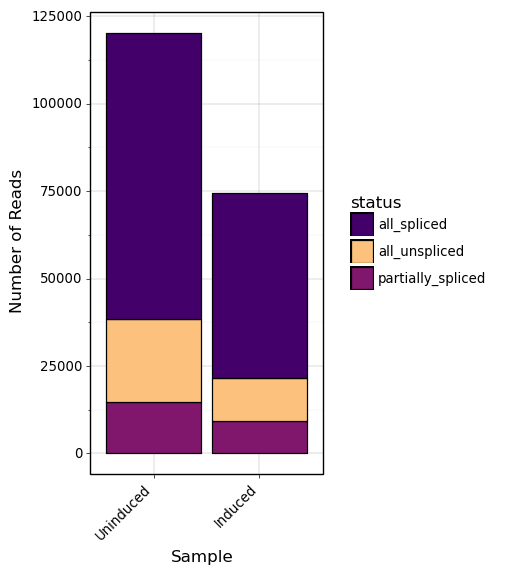

<ggplot: (8795255448217)>

In [54]:
# Plot number of reads by splicing status for treated and untreated conditions

my_colours = ['#43006A', '#FBC17D', '#81176D']

plt_status_number = (ggplot
#      (data=df_by_read, mapping=aes( x='sample', fill = 'status' )) + 
     (data=df_by_read, mapping=aes(x='treatment', fill = 'status')) + 
      geom_bar(stat = 'count', position = 'stack', colour = 'black') +
      theme_linedraw(base_size = 12) +
      theme(axis_text_x=element_text(rotation=45, hjust=1)) +
      theme(figure_size = (3,6)) +
      xlab('Sample') +
      ylab('Number of Reads') +
#       ylim(0,85000) +
#       scale_fill_brewer(palette = 'YlGnBu') +
      scale_fill_manual(values = my_colours)
    )

plt_status_number

In [55]:
# calculate fraction of all considered introns that are spliced for each treatment condition and in total

spliced = df_by_read['spliced_exact'].sum()
unspliced = df_by_read['unspliced'].sum()

fraction_spliced = spliced/(spliced+unspliced)

print('Number of unspliced introns total is ' + str(float(unspliced)))
print('Number of spliced introns total is ' + str(float(spliced)))
print('Fraction spliced total is ' + str(float(fraction_spliced)))
print('\n')


uninduced = df_by_read.loc[df_by_read['treatment'] == 'Uninduced']
induced = df_by_read.loc[df_by_read['treatment'] == 'Induced']

spliced_uninduced = uninduced['spliced_exact'].sum()
unspliced_uninduced = uninduced['unspliced'].sum()

fraction_spliced_uninduced = spliced_uninduced/(spliced_uninduced+unspliced_uninduced)

print('Number of unspliced introns uninduced is ' + str(float(unspliced_uninduced)))
print('Number of spliced introns uninduced is ' + str(float(spliced_uninduced)))
print('Fraction spliced uninduced is ' + str(float(fraction_spliced_uninduced)))
print('\n')

spliced_induced = induced['spliced_exact'].sum()
unspliced_induced = induced['unspliced'].sum()

fraction_spliced_induced = spliced_induced/(spliced_induced+unspliced_induced)

print('Number of unspliced introns induced is ' + str(float(unspliced_induced)))
print('Number of spliced introns induced is ' + str(float(spliced_induced)))
print('Fraction spliced induced is ' + str(float(fraction_spliced_induced)))

Number of unspliced introns total is 81407.0
Number of spliced introns total is 603311.0
Fraction spliced total is 0.8811087192099522


Number of unspliced introns uninduced is 50764.0
Number of spliced introns uninduced is 362075.0
Fraction spliced uninduced is 0.8770368109602048


Number of unspliced introns induced is 30643.0
Number of spliced introns induced is 241236.0
Fraction spliced induced is 0.8872917731785096


In [56]:
# calculate number of reads by splicing status
all_spliced_df = df_by_read.loc[df_by_read['status'] == 'all_spliced']
all_unspliced_df = df_by_read.loc[df_by_read['status'] == 'all_unspliced']
partially_spliced_df = df_by_read.loc[df_by_read['status'] == 'partially_spliced']

print('Number of all spliced reads: ' + str(len(all_spliced_df)))
print('Number of all unspliced reads: ' + str(len(all_unspliced_df)))
print('Number of partially spliced reads: ' + str(len(partially_spliced_df)))

Number of all spliced reads: 134581
Number of all unspliced reads: 35982
Number of partially spliced reads: 24102


In [57]:
all_spliced_uninduced = len((all_spliced_df[all_spliced_df['treatment'] == 'Uninduced']).index)
partially_spliced_uninduced = len((partially_spliced_df[partially_spliced_df['treatment'] == 'Uninduced']).index)
all_unspliced_uninduced = len((all_unspliced_df[all_unspliced_df['treatment'] == 'Uninduced']).index)

all_spliced_induced = len((all_spliced_df[all_spliced_df['treatment'] == 'Induced']).index)
partially_spliced_induced = len((partially_spliced_df[partially_spliced_df['treatment'] == 'Induced']).index)
all_unspliced_induced = len((partially_spliced_df[partially_spliced_df['treatment'] == 'Induced']).index)

total_uninduced = all_spliced_uninduced + partially_spliced_uninduced + all_unspliced_uninduced
total_induced = all_spliced_induced + partially_spliced_induced + all_unspliced_induced

data_list = [['Uninduced', 'all_spliced', all_spliced_uninduced, total_uninduced],
             ['Uninduced', 'partially_spliced', partially_spliced_uninduced, total_uninduced],
             ['Uninduced', 'all_unspliced', all_unspliced_uninduced, total_uninduced],
             ['Induced', 'all_spliced', all_spliced_induced, total_induced],
             ['Induced', 'partially_spliced', partially_spliced_induced, total_induced],
             ['Induced', 'all_unspliced', all_unspliced_induced, total_induced]]

# Create the pandas DataFrame 
df_splicing_status_fraction = pd.DataFrame(data_list, columns = ['treatment', 'splicing_status', 'count', 'total']) 
df_splicing_status_fraction['fraction'] = df_splicing_status_fraction['count']/df_splicing_status_fraction['total']

cat_type = CategoricalDtype(categories=['Uninduced', 'Induced'], ordered=True) # turn group column into a category variable in order to control order of plotting
df_splicing_status_fraction['treatment'] = df_splicing_status_fraction['treatment'].astype(cat_type)
df_splicing_status_fraction

,treatment,splicing_status,count,total,fraction
0,Uninduced,all_spliced,81714,120143,0.680140
1,Uninduced,partially_spliced,14716,120143,0.122487
2,Uninduced,all_unspliced,23713,120143,0.197373
3,Induced,all_spliced,52867,71639,0.737964
4,Induced,partially_spliced,9386,71639,0.131018
5,Induced,all_unspliced,9386,71639,0.131018


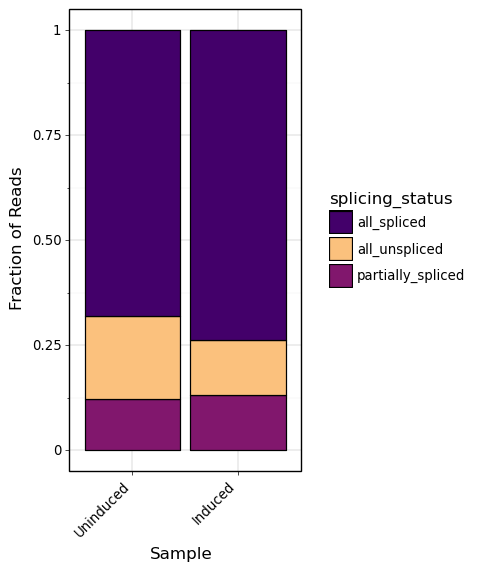

<ggplot: (8795255389337)>

In [58]:
# Plot fraction of reads by splicing status for treated and untreated conditions

my_colours = ['#43006A', '#FBC17D', '#81176D']

plt_status_fraction = (ggplot
#      (data=df_by_read, mapping=aes( x='sample', fill = 'status' )) + 
     (data=df_splicing_status_fraction, mapping=aes(x='treatment', y='fraction', fill = 'splicing_status')) + 
      geom_bar(stat = 'identity', position = 'stack', colour = 'black') +
      theme_linedraw(base_size = 12) +
      theme(axis_text_x=element_text(rotation=45, hjust=1)) +
      theme(figure_size = (3,6)) +
      xlab('Sample') +
      ylab('Fraction of Reads') +
#       ylim(0,85000) +
#       scale_fill_brewer(palette = 'YlGnBu') +
      scale_fill_manual(values = my_colours)
    )

plt_status_fraction

In [59]:
# Group combined data by gene and calculate coSE
combined_by_gene = []
for df in combined_df:
    combined_by_gene.append(group_by_gene(df))
    
df_by_gene = pd.concat(combined_by_gene)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-2198...done.
Finished.
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-6659...done.
Finished.
2 input query terms found no hit:
	['ENSMUST00000216595', 'ENSMUST00000227473']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-3849...done.
Finished.
2 input query terms found no hit:
	['ENSMUST00000026900', 'ENSMUST00000227473']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-7646...done.
Finished.
4 input query terms found no hit:
	['ENSMUST000000

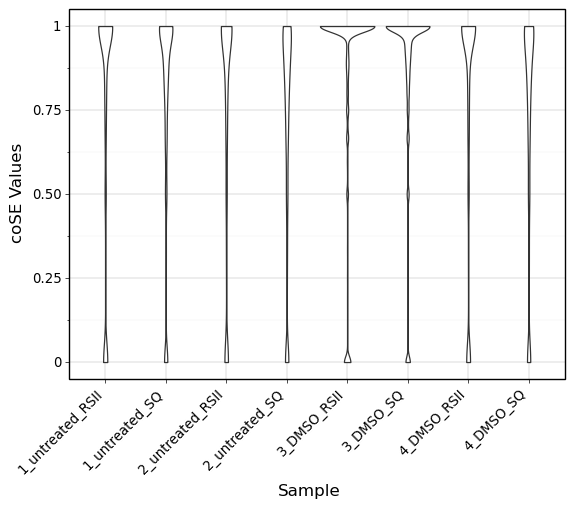

<ggplot: (8795254092773)>

In [60]:
# Plot distribution of coSE values for each sample

plt_cose_dist = (ggplot
     (data=df_by_gene, mapping=aes( x='sample', y = 'coSE')) + 
      geom_violin() +
      theme_linedraw(base_size = 12) +
      theme(axis_text_x=element_text(rotation=45, hjust=1)) +
      xlab('Sample') +
      ylab('coSE Values')
#       geom_jitter(height = 0, width = 0.1, alpha = 0.05)
           )

plt_cose_dist

In [61]:
# Group uninduced and induced samples together
df_by_gene['sample'] = df_by_gene['sample'].astype('string')
df_by_gene['treatment'] = pd.np.where(df_by_gene['sample'].str.contains("untreated"), "Uninduced", "Induced") # group by uninduced or DMSO string in sample name
cat_type = CategoricalDtype(categories=['Uninduced', 'Induced'], ordered=True) # turn group column into a category variable in order to control order of plotting


df_by_gene['treatment'] = df_by_gene['treatment'].astype(cat_type) 

In [62]:
# Split into two dataframes based on treatment, then group by gene and recalculate coSE
df_uninduced = df_by_gene[df_by_gene['treatment'] == 'Uninduced']
df_induced = df_by_gene[df_by_gene['treatment'] == 'Induced']

df_uninduced_g = df_uninduced.groupby(['ensembl.gene']).agg({
    'n_reads':'sum',
    'spliced': 'sum',
    'unspliced':'sum',
    'treatment':'first',
    'symbol':'first'
})

df_induced_g = df_induced.groupby(['ensembl.gene']).agg({
    'n_reads':'sum',
    'spliced': 'sum',
    'unspliced':'sum',
    'treatment':'first',
    'symbol':'first'
})

df_uninduced_g['coSE'] = df_uninduced_g['spliced']/(df_uninduced_g['spliced'] + df_uninduced_g['unspliced'])
df_induced_g['coSE'] = df_induced_g['spliced']/(df_induced_g['spliced'] + df_induced_g['unspliced'])

df_uninduced_g.columns = ['n_reads_u', 'spliced_u', 'unspliced_u', 'treatment', 'symbol', 'coSE_u']
df_induced_g.columns = ['n_reads_i', 'spliced_i', 'unspliced_i', 'treatment', 'symbol', 'coSE_i']

In [63]:
# Combine dataframes by gene, keeping only rows which have reads in both treatment conditions

by_gene_merged = pd.merge(df_uninduced_g, df_induced_g, how = 'inner', left_index = True, right_index = True, sort = False)
cov_10 = by_gene_merged[(by_gene_merged['n_reads_u'] > 9) & (by_gene_merged['n_reads_i'] > 9)]
cov_5 = by_gene_merged[(by_gene_merged['n_reads_u'] > 4) & (by_gene_merged['n_reads_i'] > 4)]
cov_3 = by_gene_merged[(by_gene_merged['n_reads_u'] > 2) & (by_gene_merged['n_reads_i'] > 2)]

print('Number of genes with at least 10 reads in both conditions: ' + str(len(cov_10.index)))
print('Number of genes with at least 5 reads in both conditions: ' + str(len(cov_5.index)))
print('Number of genes with at least 3 reads in both conditions: ' + str(len(cov_3.index)))

Number of genes with at least 10 reads in both conditions: 3680
Number of genes with at least 5 reads in both conditions: 4911
Number of genes with at least 3 reads in both conditions: 5697


In [64]:
# Remove rows that have a nan value
cov_10 = cov_10.reset_index()
keep = np.isnan(cov_10['coSE_i']) == False
cov_10 = cov_10[keep]

In [66]:
len(cov_10)

3678

R-value: 0.5752970056500079
p-value: 3e-323


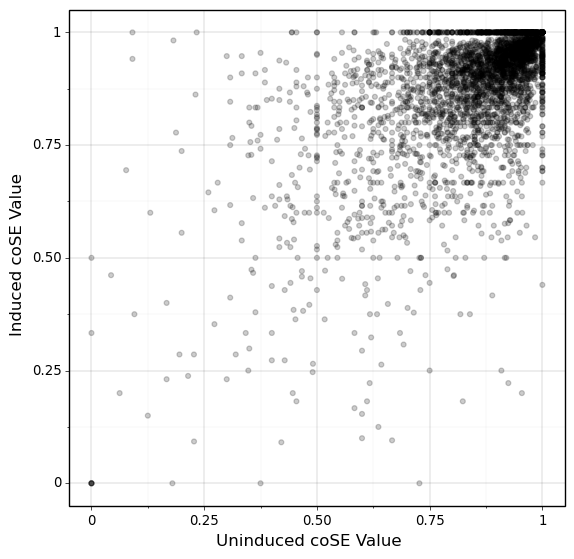

<ggplot: (8795252996853)>

In [65]:
# Plot coSE values comparing between uninduced and induced conditions

# Calculate linear least-squares regression (second output [2] is correlation coefficient float)
r_value, p_value = scipy.stats.pearsonr(x = cov_10['coSE_u'], y = cov_10['coSE_i'])
# print("R-value: %f    R-squared: %f" % (slope, r_value**2))
print('R-value: ' + str(r_value))
print('p-value: ' + str(p_value))

plt_cose_scatter = (ggplot
     (data=cov_10, mapping=aes( x='coSE_u', y = 'coSE_i')) + 
#       geom_text(label = R2) +
      geom_point(alpha = 0.2) +
#       geom_bin2d(binwidth = .01, drop = False) + #to fill in all grey background
      scale_fill_cmap(name = 'magma') +
      theme_linedraw(base_size = 12) +
      theme(aspect_ratio = 1) +
      xlab('Uninduced coSE Value') +
      ylab('Induced coSE Value')
           )
      
plt_cose_scatter

In [57]:
# Calcuate fraction of genes which have coSE > 0.9 in both conditions
highcose = cov_10[(cov_10['coSE_u'] > 0.9) & (cov_10['coSE_i'] > 0.9)]
n_highcose = len(highcose.index)
n_cov_10 = len(cov_10.index)

print('Fraction of genes with coSE > 0.9 is ' + str(n_highcose/n_cov_10))

Fraction of genes with coSE > 0.9 is 0.3520935290918978


### Part 4: Save Outputs

In [ ]:
# df_by_intron.to_csv('splicing_status_by_intron.csv',
#                      sep = '\t',
#                      header = True,
#                      index = False)

In [67]:
# Write output files

# Plots
plt_status_number.save('splicing_status_combined_count.pdf')
plt_status_fraction.save('splicing_status_combined_fraction.pdf')
plt_cose_dist.save('cose_distributions.pdf')
plt_cose_scatter.save('cose_scatter_uninduced_induced.pdf')

# Data grouped by readname (for read splicing status)
output_filename = "combined_data_{window}_bp_window_splicing_status_counted.bed".format(**locals()) # save filename with window as specified above
out_cols = ['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'r_start', 'r_end', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'sample', 'spliced_exact', 'unspliced', 'total', 'status']
out_col_names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'sample', 'spliced_introns', 'unspliced_introns', 'total_introns', 'splicing_status']
df_by_read.to_csv(output_filename, 
               sep = '\t', 
               index = False,
               columns = out_cols,   
               header = out_col_names)

# Data grouped by gene (for coSE values)
by_gene_merged.to_csv('coSE_values_per_gene.txt', 
               sep = '\t', 
               index = True, 
               header = True)

In [68]:
# BED12 files of reads separated by splicing status
all_spliced_out = all_spliced_df[['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'r_start', 'r_end', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'status', 'treatment']]
all_unspliced_out = all_unspliced_df[['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'r_start', 'r_end', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'status', 'treatment']]
partially_spliced_out = partially_spliced_df[['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'r_start', 'r_end', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'status', 'treatment']]

bed12_out_cols = ['r_chr', 'r_start', 'r_end', 'r_name', 'r_score', 'r_strand', 'r_thickStart', 'r_thickEend', 'r_rgb', 'r_blocks', 'r_blockSizes', 'r_blockStarts', 'status', 'treatment']

all_spliced_out.to_csv('all_spliced_reads.bed', 
               sep = '\t', 
               index = False,
#                columns = bed12_out_cols,   
               header = False)

all_unspliced_out.to_csv('all_unspliced_reads.bed', 
               sep = '\t', 
               index = False,
#                columns = bed12_out_cols,   
               header = False)

partially_spliced_out.to_csv('partially_spliced_reads.bed', 
               sep = '\t', 
               index = False,
#                columns = bed12_out_cols,   
               header = False)

In [69]:
# Generate two files (uninduced and induced) with reads coloured by splicing status

# Read in all reads so these can be merged with splicing status classified reads
allBEDfiles = [
    '../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
    '../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed'
]

all_reads = []
for file in allBEDfiles:
    bed12 = pd.read_csv(file, sep = '\t', names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts'])
    treatment = file.split('/')[-1].split('_')[1] # get sample ID from file name
    if treatment == 'DMSO':
            bed12['condition'] = 'Induced'
    if treatment == 'untreated':
            bed12['condition'] = 'Uninduced'
    all_reads.append(bed12)
    
allreads = pd.concat(all_reads)

# read in classified reads
allSpliced = pd.read_csv('all_spliced_reads.bed', sep = '\t', names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts', 'splicing_status', 'condition'])
partiallySpliced = pd.read_csv('partially_spliced_reads.bed', sep = '\t', names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts', 'splicing_status', 'condition'])
allUnspliced = pd.read_csv('all_unspliced_reads.bed', sep = '\t', names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'rgb', 'blocks', 'blockSizes', 'blockStarts', 'splicing_status', 'condition'])
status_classified = pd.concat([allSpliced, partiallySpliced, allUnspliced])

# merge the two dataframes so that reads that are unclassified get NaN status
all_reads_status_classified = pd.merge(allreads, 
                                       status_classified[['name', 'splicing_status']],
                                       left_on = ['name'],
                                       right_on = ['name'],
                                       how = 'left')

# assign rbg colour based on splicing status classification
all_reads_status_classified['splicing_status'] = all_reads_status_classified['splicing_status'].astype('str')
all_reads_status_classified.loc[all_reads_status_classified.splicing_status == 'all_spliced', 'rgb'] = '67,0,106'
all_reads_status_classified.loc[all_reads_status_classified.splicing_status == 'partially_spliced', 'rgb'] = '129,23,109'
all_reads_status_classified.loc[all_reads_status_classified.splicing_status == 'all_unspliced', 'rgb'] = '251,193,125'
all_reads_status_classified.loc[all_reads_status_classified.splicing_status == 'nan', 'rgb'] = '97,100,99'

# separate by induced/uninduced
uninduced_coloured = all_reads_status_classified.loc[all_reads_status_classified['condition'] == 'Uninduced']
induced_coloured = all_reads_status_classified.loc[all_reads_status_classified['condition'] == 'Induced']

# write two BED12 files as output to open in IGV and make figures
uninduced_coloured.to_csv('uninduced_coloured.bed', 
               sep = '\t', 
               index = False,
               header = False)
induced_coloured.to_csv('induced_coloured.bed', 
               sep = '\t', 
               index = False,
               header = False)

In [231]:
# # BAM files of reads separated by splicing status (for downstream metagene coverage)

# # Get readnames that are all_spliced, all_unspliced, partially_spliced and save as lists
# all_spliced_readnames = df_by_read.loc[df_by_read['status'] == 'all_spliced', 'r_name'].tolist()
# all_unspliced_readnames = df_by_read.loc[df_by_read['status'] == 'all_unspliced', 'r_name'].tolist()
# partially_spliced_readnames = df_by_read.loc[df_by_read['status'] == 'partially_spliced', 'r_name'].tolist()

# # Combine BAM files from all samples of filtered reads to separate by splicing stauts
# pysam.merge('combined_all_reads.bam', 
#           '../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted.bam', 
#           '../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted.bam',
#           catch_stdout=False)

# pysam.merge('combined_untreated_reads.bam', 
#           '../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted.bam', 
#           '../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted.bam',
#           catch_stdout=False)

# pysam.merge('combined_dmso_reads.bam', 
#           '../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted.bam',
#           '../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted.bam',
#           catch_stdout=False)

# pysam.sort('-o', 'combined_untreated_reads_sorted.bam', 'combined_untreated_reads.bam', catch_stdout=False)
# pysam.index('combined_untreated_reads_sorted.bam', catch_stdout=False)

# pysam.sort('-o', 'combined_dmso_reads_sorted.bam', 'combined_dmso_reads.bam', catch_stdout=False)
# pysam.index('combined_dmso_reads_sorted.bam', catch_stdout=False)

# pysam.sort('-o', 'combined_all_reads_sorted.bam', 'combined_all_reads.bam', catch_stdout=False)
# pysam.index('combined_all_reads_sorted.bam', catch_stdout=False)

In [152]:
# def separate_read_by_splicing_status(bamfile):
#     bam_in = pysam.AlignmentFile(bamfile, "rb")
    
#     all_spliced = pysam.AlignmentFile('all_spliced_reads_combined.bam', "wb", template = bam_in)
#     all_unspliced = pysam.AlignmentFile('all_unspliced_reads_combined.bam', "wb", template = bam_in)
#     partially_spliced = pysam.AlignmentFile('partially_spliced_reads_combined.bam', "wb", template = bam_in)
    
#     for read in bam_in:
        
#         rname = read.query_name
        
#         if rname in all_spliced_readnames:
#             all_spliced.write(read)
#         if rname in all_unspliced_readnames:
#             all_unspliced.write(read)
#         if rname in partially_spliced_readnames:
#             partially_spliced.write(read)
    
#     bam_in.close()
#     all_spliced.close()
#     all_unspliced.close()
#     partially_spliced.close()

In [153]:
# Save separated BAM files
# NOTE: THIS TAKES A VERY LONG TIME BUT IT WORKS
# separate_read_by_splicing_status('combined_all_reads_sorted.bam')